# Улучшение бейзлайна

## Импорты, просмотр данных

In [1]:
# Импорты
import pandas as pd
import gdown
import joblib
import numpy as np
import random
import ml_utils as mu
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

random.seed(42)
np.random.seed(42)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 80)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

`Так же, как и в ноутбуке построения бейзлайна возьмём 10% данных для подбора оптимальной модели и затем обучим итоговые модели на всех данных (подбор моделей на всех данных сразу слишком длительный процесс)`

### Загрузка данных

In [ ]:
# Сэмпл датасета (10%) для подбора оптимальной модели
sample_10_id = '17IVd8t37FZ-WULTMCnsUv8vbd6PuzeKx'
gdown.download(f"https://drive.google.com/uc?id={sample_10_id}", quiet=True)

# 50% датасета (которые поместились в 32гб оперативки)
df_50_id = '12mIlvk7Fb7yfdvoml7dmE-8TuGLh4c-V'
gdown.download(f"https://drive.google.com/uc?id={df_50_id}", quiet=True)

# Если понадобится - полный датасет (400к статей)
# df_100_id = '1YvQ2kxQqq1JJBfzTqygftj_RMOnV0ZTd'
# gdown.download(f"https://drive.google.com/uc?id={df_100_id}", quiet=False)

### Предобработка данных

In [2]:
# Сэмпл данных - 10% от датасета
df = pd.read_parquet("sample_10.parquet")

In [3]:
df.head(2)

,author,publication_date,hubs,comments,views,url,reading_time,individ/company,bookmarks_cnt,text_length,rating_new,text_pos_tags,tags_tokens,title_tokens,text_tokens
0,vilianov,2015-06-05 08:47:01+00:00,"Блог компании AMD, Компьютерное железо, Ноутбуки",31,11000,https://habr.com/ru/companies/amd/articles/380253/,4.0,company,5.0,6000,20.0,"[ADV, ADV, ADP, NOUN, VERB, NUM, ADP, ADJ, PROPN, NOUN, CCONJ, ADP, ADJ, NOU...","[amd, amd, cpu, gpu, apu, carrizo]","[amd, computex, apu, шестой, поколение, готовый, взбодрить, портативный, ноу...","[прямо, тайвань, проходить, главный, itвыставок, планета, компьютерный, инду..."
1,SLY_G,2024-03-02 07:57:14+00:00,"Занимательные задачки, Математика, Научно-популярное",86,38000,https://habr.com/ru/articles/797537/,6.0,individual,54.0,9489,40.0,"[ADJ, NOUN, VERB, NOUN, ADP, NOUN, SPACE, ADV, VERB, DET, NOUN, ADP, PROPN, ...",[комбинаторика],"[получать, деньга, подбрасывание, монета, стоимость, миллион, доллар]","[безотказный, способ, вовлечь, человек, дискуссия, регулярно, публиковать, ш..."


In [4]:
# Выделение рейтинга статьи
df['rating_level'] = mu.categorize_ratings(df)

# Предобработка датасета: фильтрация, объединение текстовых токенов,
# кодировка меток(хабов) и преобразование рейтингов
(df_prepr, y_multi_reduced, selector, 
index_to_label, mlb, 
y_rating, inverse_rating_mapping, indices) = mu.df_preprocess(df)

## Работа с признаками

In [ ]:
# Оставим только необходимые столбцы
X = df_prepr.drop(columns=['author', 'publication_date', 'url', 'text_pos_tags', 'hubs', 'rating_level', 'rating_new', 'hubs_encoded']).copy()

# Кодировка individ/company
X['individ/company'] = X['individ/company'].map({'individual': 0, 'company': 1})
X = X.rename(columns={'individ/company':'is_company'})

# Выделям матрицы признаков признаков для хабов и рейтинга
X_hubs = X.iloc[indices].copy()
X_rating = X.copy()

# Выделяем нужные столбцы
text_col = 'text_combined'
num_cols= ['comments', 'views', 'reading_time', 'bookmarks_cnt', 'text_length']

# Пайплайны (числовой, текстовый) для предсказания хабов (тем) статей
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2)))])
numeric_pipeline = Pipeline([('scaler', StandardScaler())])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor = ColumnTransformer([
    ('text', text_pipeline, text_col),
    ('num', numeric_pipeline, num_cols)])

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hubs, y_multi_reduced, test_size=0.25)

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_rating, test_size=0.25)

In [6]:
X_hubs.head()

,comments,views,reading_time,is_company,bookmarks_cnt,text_length,text_combined
0,31,11000,4.0,1,5.0,6000,amd amd cpu gpu apu carrizo amd computex apu шестой поколение готовый взбодр...
1,86,38000,6.0,0,54.0,9489,комбинаторика получать деньга подбрасывание монета стоимость миллион доллар ...
2,26,4400,10.0,0,44.0,15239,docker ide c qtcreator virtualization containers рабочий c ide docker contai...
3,0,7100,4.0,0,82.0,5066,шейдеры постобработка shaders спецэффект unityd зрение хищник эффект термаль...
4,15,24000,16.0,1,124.0,26101,антипаттерны микросервисы архитектура архитектурный антипаттерны микросервис...


### Лучшая модель бейзлайна для хабов

In [ ]:
# Пайплайн для предсказания хабов (параметры выбраны как лучшие, полученные при построении бейзлайна)
pipeline_h = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter=1000, C=0.1, random_state=42), n_jobs=-1))])

# Обучение и предсказание по лучшему пайплайну для хабов
pipeline_h.fit(X_train_h, y_train_h)
y_pred_h = pipeline_h.predict(X_test_h)

In [8]:
# Расчёт метрик для предсказания хабов
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.811, 'Recall': 0.2921, 'F1-Score': 0.4296, 'Hamming Loss': 0.0202}
macro - {'Precision': 0.7264, 'Recall': 0.2365, 'F1-Score': 0.3315, 'Hamming Loss': 0.0202}
weighted - {'Precision': 0.7561, 'Recall': 0.2921, 'F1-Score': 0.3923, 'Hamming Loss': 0.0202}


`Baseline Recap (Hubs)`
* При использовании только текста статьи как основного признака у модели был высокий Recall (~66%), большая часть релевантных статей были выявлены
* При этом наблюдался низкий Precision (~31-36%)
* Значение F1-score был средним (39-46%), низкая точность вносила свой негативный вклад

`Выводы по метрикам при использовании всех признаков`
* Модель имеет высокий Precision (~73-81%), предсказанные темы статей в большинстве случаев верны
* Наблюдается низкий Recall (~23-29%), модель пропускает много статей, которые должны были быть отнесены к определенной теме
* Снижение Recall отрицательно сказывается на F1-Score (~33–43%), итоговый баланс между Precision и Recall оказывается хуже для взвешенных и макро-метрик, и примерно на том же уровне, чем при использовании только текста

`Общие выводы`
* При использовании только текста достигается лучшая полнота (Recall), однако это происходит за счёт увеличения числа ложных срабатываний (низкий Precision)
* Добавление дополнительных признаков делает модель более «консервативной» — она предсказывает тему только в тех случаях, когда уверена (высокий Precision), но при этом пропускает многие релевантные статьи (низкий Recall)
* Незначительное отличие в Hamming Loss (0.0202 против 0.0186) указывает на схожую общую ошибочность по отдельным меткам, однако распределение ошибок (ложные срабатывания и пропущенные примеры) существенно различается

### Лучшая модель бейзлайна для рейтинга

In [ ]:
# Пайплайн для предсказания рейтинга (параметры выбраны как лучшие, полученные при построении бейзлайна)
pipeline_r = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=5000, C=1, solver='sag', random_state=42))])

# Обучение и предсказание по лучшему пайплайну для рейтинга
pipeline_r.fit(X_train_r, y_train_r)
y_pred_r = pipeline_r.predict(X_test_r)

In [10]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.633, 'Recall': 0.633, 'F1-Score': 0.633, 'Hamming Loss': 0.367}
macro - {'Precision': 0.6619, 'Recall': 0.3948, 'F1-Score': 0.3989, 'Hamming Loss': 0.367}
weighted - {'Precision': 0.6404, 'Recall': 0.633, 'F1-Score': 0.6188, 'Hamming Loss': 0.367}


`Baseline Recap (Rating)`
* Микро-метрики равны 0.47, что показывает среднее качество модели
* Макро-метрики были довольно низкими (Precision - 0.26, Recall - 0.28, F1 - 0.26), учитывая что в наших данных сильный дизбаланс классов, модель не могла качественно предсказывать редкие классы
* Hamming Loss был довольно высоким (0.53), что говорит о невысокой точности модели

`Выводы по метрикам при использовании всех признаков`
* Микро-метрики выросли до 0.63, что указывает на хороший буст в сравнении с моделью бейзлайна, построенном только на текстовых признаках
* Макро-метрики также выросли (Precision - 0.66, Recall - 0.395 и F1 - 0.399), рост этих метрик указывает на более равномерное качество предсказаний по всем классам
* Hamming Loss уменьшился с 0.53 до 0.37, что говорит о том, что модель делает меньше ошибок при классификации

`Общие выводы`
* Добавление дополнительных признаков существенно повышает как общую (микро), так и классовую (макро и взвешенные) эффективность модели для предикта рейтинга статей

## Обучение бустингов и случайного леса

### Хабы

In [ ]:
# Добавим снижение размерности данных в текстовый пайплайн, чтобы избежать проклятия размерности в нелинейных моделях
text_pipeline_svd = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=50, random_state=42))])
numeric_pipeline = Pipeline([('scaler', StandardScaler())])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor_svd = ColumnTransformer([
    ('text', text_pipeline_svd, text_col),
    ('num', numeric_pipeline, num_cols)])

In [ ]:
# Пайплайн с CatBoostClassifier
pipeline_cat_h = Pipeline([
    ('preprocessor', preprocessor_svd),
    ('clf', OneVsRestClassifier(CatBoostClassifier(random_state=42, thread_count=-1, silent=True)))])

# Обучение модели и предсказание хабов
pipeline_cat_h.fit(X_train_h, y_train_h)
y_pred_h_cat = pipeline_cat_h.predict(X_test_h)

In [ ]:
# Сохранение модели для предсказания хабов
joblib.dump(pipeline_cat_h, 'pipeline_cat_h.pkl')

# Расчёт метрик для предсказания хабов
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h_cat, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.8194, 'Recall': 0.4836, 'F1-Score': 0.6082, 'Hamming Loss': 0.0162}
macro - {'Precision': 0.8241, 'Recall': 0.4462, 'F1-Score': 0.5613, 'Hamming Loss': 0.0162}
weighted - {'Precision': 0.8199, 'Recall': 0.4836, 'F1-Score': 0.5909, 'Hamming Loss': 0.0162}


In [14]:
# Пайплайн со случайным лесом
pipeline_rf_h = Pipeline([
    ('preprocessor', preprocessor_svd),
    ('clf', OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, random_state=42)))])

# Обучение модели и предсказание хабов
pipeline_rf_h.fit(X_train_h, y_train_h)
y_pred_rf_h = pipeline_rf_h.predict(X_test_h)

In [16]:
# Расчёт метрик для предсказания хабов
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_rf_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.8831, 'Recall': 0.4134, 'F1-Score': 0.5632, 'Hamming Loss': 0.0167}
macro - {'Precision': 0.901, 'Recall': 0.3702, 'F1-Score': 0.5106, 'Hamming Loss': 0.0167}
weighted - {'Precision': 0.893, 'Recall': 0.4134, 'F1-Score': 0.5485, 'Hamming Loss': 0.0167}


In [ ]:
# Пайплайн с CatBoostClassifier и переданным текстовым столбцом в качестве text_feature
pipeline_cat_text_h = Pipeline([
    ('clf', OneVsRestClassifier(CatBoostClassifier(random_state=42, task_type='GPU', 
                                                   text_features=['text_combined'], silent=True)))])

# Обучение модели и предсказание хабов
pipeline_cat_text_h.fit(X_train_h, y_train_h)
y_pred_h_cat_text = pipeline_cat_text_h.predict(X_test_h)

In [ ]:
# Сохранение модели для предсказания хабов (тем) статей
joblib.dump(pipeline_cat_text_h, 'pipeline_cat_text_h.pkl')

# Расчёт метрик для предсказания хабов
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h_cat_text, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.782, 'Recall': 0.5319, 'F1-Score': 0.6332, 'Hamming Loss': 0.0161}
macro - {'Precision': 0.7828, 'Recall': 0.5052, 'F1-Score': 0.5978, 'Hamming Loss': 0.0161}
weighted - {'Precision': 0.7784, 'Recall': 0.5319, 'F1-Score': 0.6145, 'Hamming Loss': 0.0161}


`Выводы по нелинейным моделям для предсказания хабов`
* По сравнению с LinearSVC нелинейные модели показали буст в качестве, можем наблюдать улучшение всех основых метрик (по всем усреднениям)
* Catboost (TFIDF) показывает значительно большую полноту по сравнению с LinearSVC (0.48 и 0.29), при этом точность немного выросла (0.82 и 0.81), также значительно вырос и F1-score (с 0.43 до 0.61), таким образом получилось достичь достойного баланса между точностью и полнотой предсказаний тем статей
* Случайный лес демонстрирует самую высокую точность из всех моделей (0.89), но полнота меньше, чем у других нелинейных моделей (0.41 против 0.48/0.53), как и значение F1-score (0.56 против 0.61/0.63)
* Catboost (text_features) из всех моделей показывает лучшие значения полноты (0.53) и самый высокий F1-score (0.63), при это обучение модели заняло примерно в 5 раз больше времени, чем Catboost (TFIDF) и это только на 10% данных, на полном датасете разница во времени обучения может быть ещё более значимой
* Самой оптимальной моделью из всех для предикта хабов является CatBoost (TFIDF), она обеспечивает достойные метрики и её обучение не занимает слишком длительное время (по сравнению с Catboost (text_features))

### Рейтинг

In [20]:
# Пайплайн со случайным лесом
pipeline_rf_r = Pipeline([
    ('preprocessor', preprocessor_svd),
    ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

# Обучение модели и предсказание рейтинга
pipeline_rf_r.fit(X_train_r, y_train_r)
y_pred_rf_r = pipeline_rf_r.predict(X_test_r)

In [21]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_rf_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.702, 'Recall': 0.702, 'F1-Score': 0.702, 'Hamming Loss': 0.298}
macro - {'Precision': 0.8314, 'Recall': 0.5293, 'F1-Score': 0.5903, 'Hamming Loss': 0.298}
weighted - {'Precision': 0.7194, 'Recall': 0.702, 'F1-Score': 0.6963, 'Hamming Loss': 0.298}


In [23]:
# Пайплайн с CatBoostClassifier
pipeline_cat_r = Pipeline([
    ('preprocessor', preprocessor_svd),
    ('clf', CatBoostClassifier(random_state=42, task_type="GPU", silent=True))])

# Обучение модели и предсказание рейтинга
pipeline_cat_r.fit(X_train_r, y_train_r)
y_pred_cat_r = pipeline_cat_r.predict(X_test_r)

In [24]:
# Расчёт метрик для предсказания рейтинга
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_cat_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6928, 'Recall': 0.6928, 'F1-Score': 0.6928, 'Hamming Loss': 0.3072}
macro - {'Precision': 0.7516, 'Recall': 0.517, 'F1-Score': 0.5663, 'Hamming Loss': 0.3072}
weighted - {'Precision': 0.6997, 'Recall': 0.6928, 'F1-Score': 0.6868, 'Hamming Loss': 0.3072}


In [ ]:
# Пайплайн с CatBoostClassifier и переданным текстовым столбцом в качестве text_feature
pipeline_cat_text_r = Pipeline([
    ('clf', CatBoostClassifier(random_state=42, task_type='GPU', 
                               text_features=['text_combined'], silent=True))])

# Обучение модели и предсказание хабов
pipeline_cat_text_r.fit(X_train_r, y_train_r)
y_pred_cat_text_r = pipeline_cat_text_r.predict(X_test_r)

In [26]:
# Расчёт метрик для предсказания хабов
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_cat_text_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6964, 'Recall': 0.6964, 'F1-Score': 0.6964, 'Hamming Loss': 0.3036}
macro - {'Precision': 0.7622, 'Recall': 0.5028, 'F1-Score': 0.5441, 'Hamming Loss': 0.3036}
weighted - {'Precision': 0.705, 'Recall': 0.6964, 'F1-Score': 0.6885, 'Hamming Loss': 0.3036}


`Выводы для нелинейных моделей для предсказания рейтинга`
* Все нелинейные модели показали улучшение метрик (для всех усреднений), если смотреть по нашим целевым микро-метрикам, то улучшение по F1-score с 0.63 для Логистической регрессии до 0.7 для случайного леса и 0.69 для CatBoost
* Случайный лес демонстрирует наилучший общий результат - он показывает более высокие метрики (для всех усреднений) и обладает самым низким Hamming Loss (0.3)
* Метрики CatBoost немного хуже, чем у случайного леса, но всё равно значительно обходят логистическую регрессию
* Обучение для CatBoost (text_features) в 2 раза быстрее, чем случайный лес и Catboost (TFIDF), при этом метрики на уровне Catboost (TFIDF)

## Кривые обучения

### Хабы

`Для хабов кривые обучения за час не построились, на сэмпле данных (25%) тоже, тогда просто посмотрим метрики на трейне и тесте`

In [ ]:
pipeline_cat_h = joblib.load('pipeline_cat_h.pkl')
y_pred_h_cat_test = pipeline_cat_h.predict(X_test_h)
y_pred_h_cat_train = pipeline_cat_h.predict(X_train_h)

In [ ]:
# test
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h_cat_test, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.8194, 'Recall': 0.4836, 'F1-Score': 0.6082, 'Hamming Loss': 0.0162}
macro - {'Precision': 0.8241, 'Recall': 0.4462, 'F1-Score': 0.5613, 'Hamming Loss': 0.0162}
weighted - {'Precision': 0.8199, 'Recall': 0.4836, 'F1-Score': 0.5909, 'Hamming Loss': 0.0162}


In [10]:
# train
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_train_h, y_pred_h_cat_train, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.9968, 'Recall': 0.9131, 'F1-Score': 0.9531, 'Hamming Loss': 0.0024}
macro - {'Precision': 0.9989, 'Recall': 0.9298, 'F1-Score': 0.9617, 'Hamming Loss': 0.0024}
weighted - {'Precision': 0.9968, 'Recall': 0.9131, 'F1-Score': 0.9511, 'Hamming Loss': 0.0024}


`Выводы`
* Для модели Catboost (TFIDF) наблюдается переобучение, разница между метриками на обучающей и тестовой выборках существенная: Precision (0.99 и 0.82), Recall (0.91 и 0.48), F1-score (0.95 и 0.61), Hamming Loss (0.002 и 0.0162)

### Рейтинг

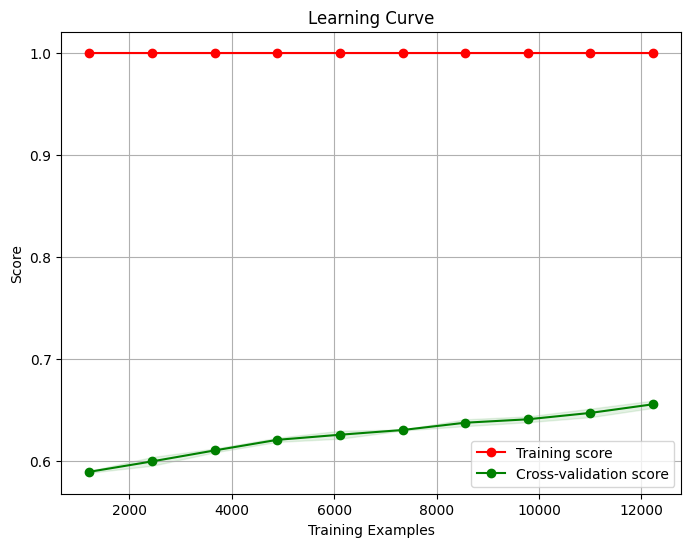

In [ ]:
# Построим кривые обучения для лучшей модели рейтингов
mu.plot_learning_curve(estimator=pipeline_rf_r, X=X_train_r, y=y_train_r, cv=3, scoring="f1_micro")

`Вывод по кривой обучения`
* Модель получилась сильно переобученной, training score практически на уровне 1.0 для любого значения выборки, при это cross-val score находится сильно ниже (0.60-0.65)
* С увеличением объёма обучающих данных cross-val score постепенно повышается

## Обучение моделей на полном наборе данных

### Предобработка данных

`Изначально планировалось обучение на полном наборе данных, но они не влезли в 32 гб оперативки) Возьмём половину датасета (211к статей)`

In [ ]:
df = pd.read_parquet("df_final_50.parquet", engine="fastparquet")
# Выделение рейтинга статьи
df['rating_level'] = mu.categorize_ratings(df)

In [ ]:
# Предобработка датасета
(df_prepr, y_multi_reduced, selector, 
index_to_label, mlb, 
y_rating, inverse_rating_mapping, indices) = mu.df_preprocess(df)

# Ужимаем df для экономии оперативки
df = df.iloc[0].copy()

# Оставим только необходимые столбцы
X = df_prepr.drop(columns=['author', 'publication_date', 'url', 'text_pos_tags', 'hubs', 'rating_level', 'rating_new', 'hubs_encoded']).copy()

# Кодировка individ/company
X['individ/company'] = X['individ/company'].map({'individual': 0, 'company': 1})
X = X.rename(columns={'individ/company':'is_company'})
X = pd.get_dummies(X, columns=['is_company'], drop_first=True)

# Выделям матрицы признаков признаков для хабов и рейтинга
X_hubs = X.iloc[indices].copy()
X_rating = X.copy()

In [4]:
# Выделяем нужные столбцы
text_col = 'text_combined'
num_cols= ['comments', 'views', 'reading_time', 'bookmarks_cnt', 'text_length']

# Добавим снижение размерности данных в текстовый пайплайн, чтобы избежать проклятия размерности в нелинейных моделях
text_pipeline_svd = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=50, random_state=42))])
numeric_pipeline = Pipeline([('scaler', StandardScaler())])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor_svd = ColumnTransformer([
    ('text', text_pipeline_svd, text_col),
    ('num', numeric_pipeline, num_cols)])

# Разделение на обучающую и тестовую выборки для предсказания хабов (тем) статей
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hubs, y_multi_reduced, test_size=0.25)

# Разделение на обучающую и тестовую выборки для предсказания рейтинга статьи
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rating, y_rating, test_size=0.25)

### Хабы

In [ ]:
# Обучение и предикт
pipeline_cat_h = Pipeline([
    ('preprocessor', preprocessor_svd),
    ('clf', OneVsRestClassifier(CatBoostClassifier(random_state=42, thread_count=-1, silent=True)))])

pipeline_cat_h.fit(X_train_h, y_train_h)
y_pred_h = pipeline_cat_h.predict(X_test_h)

In [ ]:
# Сохранение модели для предсказания хабов
joblib.dump(pipeline_cat_h, 'pipeline_h_50.pkl')

# Метрики
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_h, y_pred_h, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.7591, 'Recall': 0.4352, 'F1-Score': 0.5532, 'Hamming Loss': 0.0187}
macro - {'Precision': 0.7407, 'Recall': 0.3892, 'F1-Score': 0.4884, 'Hamming Loss': 0.0187}
weighted - {'Precision': 0.7437, 'Recall': 0.4352, 'F1-Score': 0.5279, 'Hamming Loss': 0.0187}


`Итоговые выводы`
* По сравнению с линейной моделью (SVC), обученной только на текстовых признаках, мы получили общее улучшение всех метрик (для всех усреднений) при использовании модели CatBoostClassifier, обученной на всех признаках статей
* При этом сменились акценты - по микро-метрикам (нашим основным) SVC имел высокий Recall (0.72) и низкий Precision (0.38), а CatBoost имеет высокий Precision (0.76) и средний Recall (0.44)
* Hamming Loss остался на том же уровне (SVC - 0.167, CatBoost - 0.187)
* Если смотреть по F1-Score, то улучшение на уровне 5% по микро-метрикам
* Итого - применение CatBoostClassifier для задачи предсказания тем статей является более предпочтительным благодаря лучшим метрикам качества предсказаний

### Рейтинг

In [11]:
# Обучение и предикт
pipeline_rf_r = Pipeline([
    ('preprocessor', preprocessor_svd),
    ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

pipeline_rf_r.fit(X_train_r, y_train_r)
y_pred_r = pipeline_rf_r.predict(X_test_r)

In [ ]:
# Сохранение модели для предсказания рейтинга
joblib.dump(pipeline_rf_r, 'pipeline_r_50.pkl')

# Метрики
for i in ['micro', 'macro', 'weighted']:
    lr_metrics = mu.calculate_metrics(y_test_r, y_pred_r, i)
    print(i,'-', lr_metrics)

micro - {'Precision': 0.6526, 'Recall': 0.6526, 'F1-Score': 0.6526, 'Hamming Loss': 0.3474}
macro - {'Precision': 0.7436, 'Recall': 0.4327, 'F1-Score': 0.4596, 'Hamming Loss': 0.3474}
weighted - {'Precision': 0.6659, 'Recall': 0.6526, 'F1-Score': 0.6415, 'Hamming Loss': 0.3474}


`Итоговые выводы`
* Если сравнивать с линейной моделью Logistic Regression, обученной только на текстовых признаках, то применение RandomForest даёт существенный буст по всем метрикам (и всем усреднениям)
* По микро-метрикам улучшение на уровне 15% (с 0.5 до 0.65), при этом Hamming Loss так же значительно снизился (с 0.5 до 0.35), что говорит о меньшем количестве ошибок модели при предсказании
* Наиболее сильно вырос макро-Precision (с 0.29 до 0.74), благодаря чему F1-score также вырос (с 0.29 до 0.46), то есть нелинейная модель лучше даёт предсказание для редких классов
* Итого - для задачи предсказания рейтинга статей RandomForestClassifier выглядит предпочтительнее благодаря значительному росту метрик качества предсказаний